# Teil 2: Transformieren, Extrahieren und Visualisieren von Features
## Mit Polars und Seaborn

Seaborn bietet uns eine einfache Möglichkeit um Grafiken übersichtlich und visuell ansprechend aufzubereiten, ohne uns in den komplexen Einstellungsmöglichkeiten von matplotlib zu verlieren, auf welcher seaborn basiert.  

In [65]:

import numpy as np
import scipy as sp
import polars as pl
# not all libs can work with polars/arrow data yet so we may use pandas as a crutch for now
import pandas as pd
import seaborn as sns
import altair as alt
# backend zu seaborn - nur fuer feineinstellungen
import matplotlib.pyplot as plt
# apply default seaborn theme, scaling, and color palette
sns.set_theme()

Da Seaborn, wie viele Bibliotheken, das Polars bzw. das Arrow-Format noch nicht ueberall unterstuezt, nutzen wir hier noch eine Converter Klasse von Christopher Prohm. Die Details sind erstmal nicht weiter wichtig. 

In [66]:
# Copyright (c) 2023 Christopher Prohm
# 
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
# 
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
# 
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

import functools as ft
from dataclasses import dataclass
from typing import Union

@pl.api.register_dataframe_namespace("sns")
@pl.api.register_lazyframe_namespace("sns")
@dataclass
class SeabornPlotting:
    df: Union[pl.DataFrame, pl.LazyFrame]

    def pipe(self, func, /, **kwargs):
        def maybe_collect(df):
            return df.collect() if isinstance(df, pl.LazyFrame) else df

        exprs = {}
        for key in "x", "y", "hue", "col", "row":
            val = kwargs.get(key)    
            if val is None:
                continue
            
            expr = pl.col(val) if isinstance(val, str) else val

            exprs[expr.meta.output_name()] = expr
            kwargs[key] = expr.meta.output_name()

        return (
            self.df
            .select(list(exprs.values()))
            .pipe(maybe_collect)
            .to_pandas()
            .pipe(func, **kwargs)
        )

    relplot = ft.partialmethod(pipe, sns.relplot)
    scatterplot = ft.partialmethod(pipe, sns.scatterplot)
    lineplot = ft.partialmethod(pipe, sns.lineplot)
    displot = ft.partialmethod(pipe, sns.displot)
    histplot = ft.partialmethod(pipe, sns.histplot)
    kdeplot = ft.partialmethod(pipe, sns.kdeplot)
    ecdfplot = ft.partialmethod(pipe, sns.ecdfplot)
    rugplot = ft.partialmethod(pipe, sns.rugplot)
    distplot = ft.partialmethod(pipe, sns.distplot)
    catplot = ft.partialmethod(pipe, sns.catplot)
    stripplot = ft.partialmethod(pipe, sns.stripplot)
    swarmplot = ft.partialmethod(pipe, sns.swarmplot)
    boxplot = ft.partialmethod(pipe, sns.boxplot)
    violinplot = ft.partialmethod(pipe, sns.violinplot)
    boxenplot = ft.partialmethod(pipe, sns.boxenplot)
    pointplot = ft.partialmethod(pipe, sns.pointplot)
    barplot = ft.partialmethod(pipe, sns.barplot)
    countplot = ft.partialmethod(pipe, sns.countplot)
    lmplot = ft.partialmethod(pipe, sns.lmplot)
    regplot = ft.partialmethod(pipe, sns.regplot)
    residplot = ft.partialmethod(pipe, sns.residplot)

/home/dp/source/workshop-kmu-data/env/lib64/python3.11/site-packages/polars/api.py:55: UserWarning: Overriding existing custom namespace 'sns' (on LazyFrame)
  warn(
/home/dp/source/workshop-kmu-data/env/lib64/python3.11/site-packages/polars/api.py:55: UserWarning: Overriding existing custom namespace 'sns' (on DataFrame)
  warn(


In [67]:

# read in the previously created parquet file
df = pl.read_parquet("resources/data/gta_v/gta_v_data.parquet")
df.head()

title,vehicle_class,manufacturer,features,acquisition,price,storage_location,delivery_method,modifications,resale_flag,race_availability,based_on,seats,weight_in_kg,drive_train,gears,release_date,release_dlc,lap_time,bulletproof,weapon1_resistance,weapon2_resistance,weapon3_resistance,weapon4_resistance,weapon5_resistance,speed,acceleration,braking,handling,overall,vehicle_url,upgrade_cost,resale_price_base,resale_price_upgrade,top_speed_real_kmh,top_speed_in_game_kmh,model
str,str,str,str,str,f64,str,str,str,str,str,str,i64,f64,str,str,date,str,duration[ns],str,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,str
"""Volatol""","""Planes""","""NA""","""Armored Vehicl...","""Warstock Cache...",3.724e6,"""Hangar (Person...","""Interaction Me...","""Hangar Aircraf...","""Can be sold on...","""Transform Race...","""Avro Vulcan, M...",4,40000.0,"""NA""","""NA""",2017-12-12,"""1.42 The Dooms...",53s 501ms,"""Bulletproof fr...",3,1,2,1,1,76.07,28.58,32.5,1.01,34.54,"""https://www.gt...",374150.0,2.2344e6,2.421475e6,266.35,250.0,"""Volatol"""
"""Sadler""","""Utility""","""Vapid""","""Has Variants, ...","""Can be stolen ...",35000.0,"""Garage (Person...","""Mechanic""","""Los Santos Cus...","""Can be sold if...","""Can be used in...","""First Generati...",4,2100.0,"""NA""","""5""",2013-09-17,"""1.01 Game Laun...",1m 19s 113ms,"""No""",1,1,2,1,1,69.75,50.0,20.0,62.12,50.47,"""https://www.gt...",176750.0,21000.0,109375.0,160.93,130.0,"""Sadler"""
"""Benefactor Ter...","""Commercial""","""Benefactor""","""Armored Vehicl...","""Warstock Cache...",1.375e6,"""Nightclub Ware...","""Interaction Me...","""Point of Stora...","""Cannot be sold...","""Cannot be used...","""Mercedes-Benz ...",4,10000.0,"""RWD""","""6""",2018-08-14,"""1.44 After Hou...",1m 28s 302ms,"""Bullet resista...",34,34,81,17,8,64.39,40.0,8.33,59.09,42.95,"""https://www.gt...",256000.0,0.0,0.0,140.41,120.0,"""Terrorbyte"""
"""Mammoth Dodo""","""Planes""","""Mammoth""","""Armored Vehicl...","""Elitás Travel""",500000.0,"""Pegasus Vehicl...","""Pegasus Concie...","""Paint Job Only...","""Cannot be sold...","""Transform Race...","""De Havilland C...",4,2000.0,"""RWD""","""NA""",2014-11-18,"""1.18 PS4 & Xbo...",55s 335ms,"""Bulletproof fr...",2,1,2,1,1,76.07,25.0,18.99,25.95,36.5,"""https://www.gt...",0.0,0.0,0.0,216.05,250.0,"""Dodo"""
"""Fathom FQ 2""","""SUVs""","""Fathom""","""Mystery Prize""","""Can be stolen ...",50000.0,"""Garage (Person...","""Mechanic""","""Los Santos Cus...","""Can be sold if...","""Can be used in...","""Infiniti QX70""",4,2400.0,"""NA""","""5""",2013-09-17,"""1.01 Game Laun...",1m 18s 880ms,"""No""",1,1,2,1,1,72.43,45.0,8.33,60.61,46.59,"""https://www.gt...",132200.0,30000.0,96100.0,167.37,135.0,"""FQ 2"""


Bei Listen ist es etwas schwieriger, da die Spalten nicht einfach so aufgeteilt werden können, ohne die Gesamtanzahl stark zu erhöhen.
Wir erstellen _eine_ neue Spalte, welche nur die Anzahl der Features enthält (diese sind getrennt durch Kommata).
Damit können wir zwar nicht zwischen den Features unterscheiden, aber wir können zumindest statistisch Tendenzen feststellen.


In [68]:

df = df.with_columns(
        pl.col('features').str.split(',').arr.lengths().alias('feature_count'),
        # alternative mit apply einer python lambda funktion (langsamer)
        # pl.col("features").str.split(',').apply(lambda x: len(x)).alias("feature_count"),
) 

df.get_column('feature_count')

feature_count
u32
8
3
9
7
1
3
4
2
2


Die Versionsnummer der DLCs/Patches  ist eine Zahl, welche mit jeder neuen Version erhöht wird. Das koennte interessante Zusammenhaenge aufzeigen; z.B ob die DLCs/Patches die Anzahl der Features oder den Wiederverkaufswert beeinflussen.  
Dazu muessen wir die Spalte `release_dlc` wieder aufbrechen, um die Versionsnummer als Zahl zu extrahieren.



In [69]:
df = df.with_columns(
    pl.col('release_dlc').str.split(' ').arr.slice(0,1).arr.first().cast(pl.Float64).alias('release_dlc_version'),
)

df.head()

title,vehicle_class,manufacturer,features,acquisition,price,storage_location,delivery_method,modifications,resale_flag,race_availability,based_on,seats,weight_in_kg,drive_train,gears,release_date,release_dlc,lap_time,bulletproof,weapon1_resistance,weapon2_resistance,weapon3_resistance,weapon4_resistance,weapon5_resistance,speed,acceleration,braking,handling,overall,vehicle_url,upgrade_cost,resale_price_base,resale_price_upgrade,top_speed_real_kmh,top_speed_in_game_kmh,model,feature_count,release_dlc_version
str,str,str,str,str,f64,str,str,str,str,str,str,i64,f64,str,str,date,str,duration[ns],str,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,str,u32,f64
"""Volatol""","""Planes""","""NA""","""Armored Vehicl...","""Warstock Cache...",3.724e6,"""Hangar (Person...","""Interaction Me...","""Hangar Aircraf...","""Can be sold on...","""Transform Race...","""Avro Vulcan, M...",4,40000.0,"""NA""","""NA""",2017-12-12,"""1.42 The Dooms...",53s 501ms,"""Bulletproof fr...",3,1,2,1,1,76.07,28.58,32.5,1.01,34.54,"""https://www.gt...",374150.0,2.2344e6,2.421475e6,266.35,250.0,"""Volatol""",8,1.42
"""Sadler""","""Utility""","""Vapid""","""Has Variants, ...","""Can be stolen ...",35000.0,"""Garage (Person...","""Mechanic""","""Los Santos Cus...","""Can be sold if...","""Can be used in...","""First Generati...",4,2100.0,"""NA""","""5""",2013-09-17,"""1.01 Game Laun...",1m 19s 113ms,"""No""",1,1,2,1,1,69.75,50.0,20.0,62.12,50.47,"""https://www.gt...",176750.0,21000.0,109375.0,160.93,130.0,"""Sadler""",3,1.01
"""Benefactor Ter...","""Commercial""","""Benefactor""","""Armored Vehicl...","""Warstock Cache...",1.375e6,"""Nightclub Ware...","""Interaction Me...","""Point of Stora...","""Cannot be sold...","""Cannot be used...","""Mercedes-Benz ...",4,10000.0,"""RWD""","""6""",2018-08-14,"""1.44 After Hou...",1m 28s 302ms,"""Bullet resista...",34,34,81,17,8,64.39,40.0,8.33,59.09,42.95,"""https://www.gt...",256000.0,0.0,0.0,140.41,120.0,"""Terrorbyte""",9,1.44
"""Mammoth Dodo""","""Planes""","""Mammoth""","""Armored Vehicl...","""Elitás Travel""",500000.0,"""Pegasus Vehicl...","""Pegasus Concie...","""Paint Job Only...","""Cannot be sold...","""Transform Race...","""De Havilland C...",4,2000.0,"""RWD""","""NA""",2014-11-18,"""1.18 PS4 & Xbo...",55s 335ms,"""Bulletproof fr...",2,1,2,1,1,76.07,25.0,18.99,25.95,36.5,"""https://www.gt...",0.0,0.0,0.0,216.05,250.0,"""Dodo""",7,1.18
"""Fathom FQ 2""","""SUVs""","""Fathom""","""Mystery Prize""","""Can be stolen ...",50000.0,"""Garage (Person...","""Mechanic""","""Los Santos Cus...","""Can be sold if...","""Can be used in...","""Infiniti QX70""",4,2400.0,"""NA""","""5""",2013-09-17,"""1.01 Game Laun...",1m 18s 880ms,"""No""",1,1,2,1,1,72.43,45.0,8.33,60.61,46.59,"""https://www.gt...",132200.0,30000.0,96100.0,167.37,135.0,"""FQ 2""",1,1.01


# Visualisieren der Features mit Seaborn
Jetzt koennen wir damit beginnen uns mit den Daten vertraut zu machen. Dazu erzeugen wir Grafiken der um die Abhaengigkeiten zw. den einzelnen Features zu erkennen.
Es gibt verschiedenste Arten von Grafiken, die wir verwenden koennen. Wir werden uns hier auf die folgenden beschränken:
- Histogramme
- Boxplots
- Scatterplots
- Heatmaps
- Pairplots  

Ein ganz einfaches Beispiel um den Zusammenhang zweier Variablen zu erkennen ist ein Scatterplot. Dabei werden zwei Variablen als 2D Punkt mit (x,y)-Koordinaten dargestellt.

Wir koennen z.b. Das Vehikelgewicht mit dem Top Speed vergleichen.


<Axes: xlabel='weight_in_kg', ylabel='top_speed_in_game_kmh'>

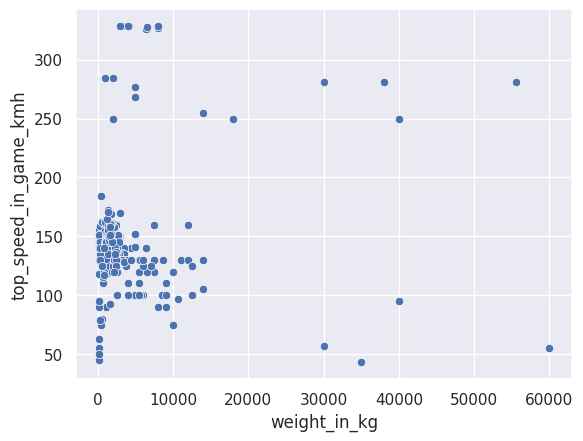

In [70]:

sns.scatterplot(x="weight_in_kg", y="top_speed_in_game_kmh", data=df)

Dieser Plot ist noch recht unuebersichtlich, da wir viele Ausreisser haben die einen klaren Zusammenhang verdecken. 
In unserem Fall haben wir auch z.B FLugzeuge unter den Fahrzeugklassen, was das Bild verfaelscht. 


In [71]:

print(df.get_column('vehicle_class').unique())

shape: (20,)
Series: 'vehicle_class' [str]
[
	"Muscle"
	"Super"
	"Motorcycles"
	"Sports Classic...
	"Sports"
	"Coupes"
	"Commercial"
	"Military"
	"Vans"
	"Cycles"
	"Utility"
	"Service"
	"Industrial"
	"SUVs"
	"Emergency"
	"Planes"
	"Sedans"
	"Compacts"
	"Off-Road"
	"Open Wheel"
]


Hier waere es wohl sinnvoll, mindestens `Planes`, `Cycles` und `Industrial` auszusortieren, um nicht Aepfel mit Birnen zu vergleichen.

/home/dp/source/workshop-kmu-data/env/lib64/python3.11/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

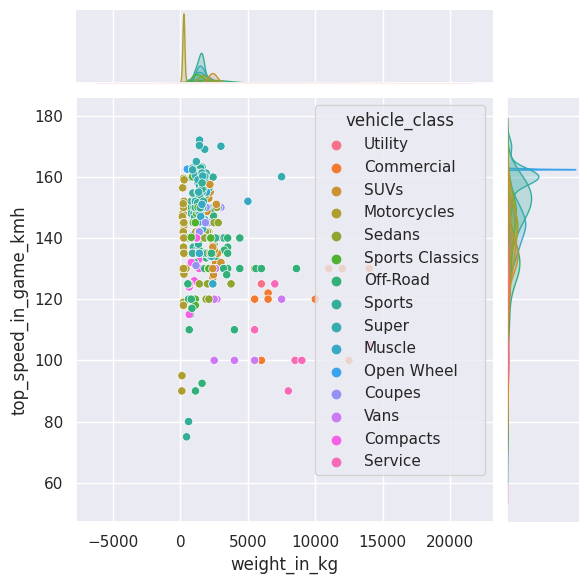

In [83]:
exclass = ['Planes', 'Cycles', 'Industrial', 'Emergency', 'Military']

dfv = df.filter(
        pl.col('vehicle_class').is_in(exclass).is_not()
).select(
        pl.exclude(['lap_time', 'release_date'])
).to_pandas()

sns.jointplot(
        data=dfv, 
        x="weight_in_kg", 
        y="top_speed_in_game_kmh", 
        hue="vehicle_class"
)


alt.Chart(dfv).mark_circle(size=60).encode(
    x='weight_in_kg',
    y='top_speed_in_game_kmh',
    color='vehicle_class',
    tooltip=['title', 'vehicle_class', 'weight_in_kg', 'top_speed_in_game_kmh']
).interactive()

/home/dp/source/workshop-kmu-data/env/lib64/python3.11/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

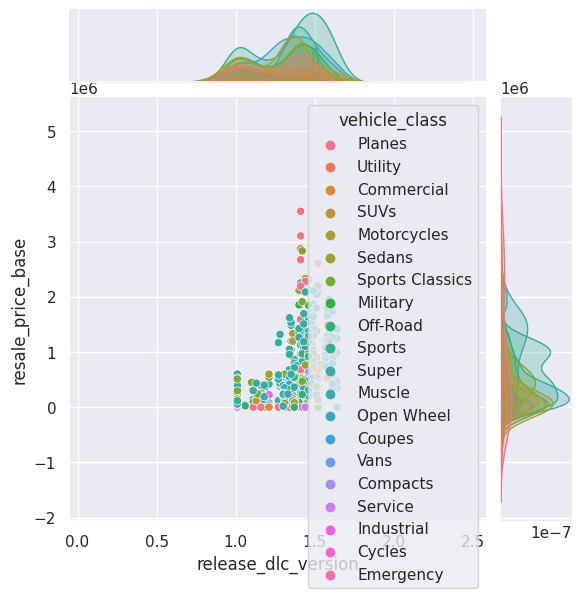

In [85]:
dfv = df.select(
        pl.exclude(['lap_time', 'release_date'])
).to_pandas()

sns.jointplot(data=dfv, x="release_dlc_version", y="resale_price_base", hue="vehicle_class")


alt.Chart(dfv).mark_circle(size=60).encode(
    x='release_dlc_version',
    y='resale_price_base',
    color='vehicle_class',
    tooltip=['title', 'vehicle_class', 'weight_in_kg', 'top_speed_in_game_kmh']
).interactive()